In [1]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [2]:
cat_directory = '../data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

filename time_abs(%Y-%m-%dT%H:%M:%S.%f)  \
0   xa.s12.00.mhz.1970-01-19HR00_evid00002     1970-01-19T20:25:00.000000   
1   xa.s12.00.mhz.1970-03-25HR00_evid00003     1970-03-25T03:32:00.000000   
2   xa.s12.00.mhz.1970-03-26HR00_evid00004     1970-03-26T20:17:00.000000   
3   xa.s12.00.mhz.1970-04-25HR00_evid00006     1970-04-25T01:14:00.000000   
4   xa.s12.00.mhz.1970-04-26HR00_evid00007     1970-04-26T14:29:00.000000   
..                                     ...                            ...   
71  xa.s12.00.mhz.1974-10-14HR00_evid00156     1974-10-14T17:43:00.000000   
72  xa.s12.00.mhz.1975-04-12HR00_evid00191     1975-04-12T18:15:00.000000   
73  xa.s12.00.mhz.1975-05-04HR00_evid00192     1975-05-04T10:05:00.000000   
74  xa.s12.00.mhz.1975-06-24HR00_evid00196     1975-06-24T16:03:00.000000   
75  xa.s12.00.mhz.1975-06-26HR00_evid00198     1975-06-26T03:24:00.000000   

    time_rel(sec)       evid    mq_type  
0         73500.0  evid00002  impact_mq  
1         12720.0  evid00003  impact_mq  
2         73020.0  evid00004  impact_mq  
3          4440.0  evid00006  impact_mq  
4         52140.0  evid00007    deep_mq  
..            ...        ...        ...  
71        63780.0  evid00156  impact_mq  
72        65700.0  evid00191  impact_mq  
73        36300.0  evid00192  impact_mq  
74        57780.0  evid00196  impact_mq  
75        12240.0  evid00198  impact_mq  

[76 rows x 5 columns]

# Applying Data preprocessing techniques

In [3]:
df = pd.read_csv(r"..\data\lunar\training\data\S12_GradeA\xa.s12.00.mhz.1970-01-19HR00_evid00002.csv")

In [4]:
row = cat[cat["filename"] == "xa.s12.00.mhz.1970-01-19HR00_evid00002"]
arrival_time = row["time_rel(sec)"][0]
arrival_time

np.float64(73500.0)

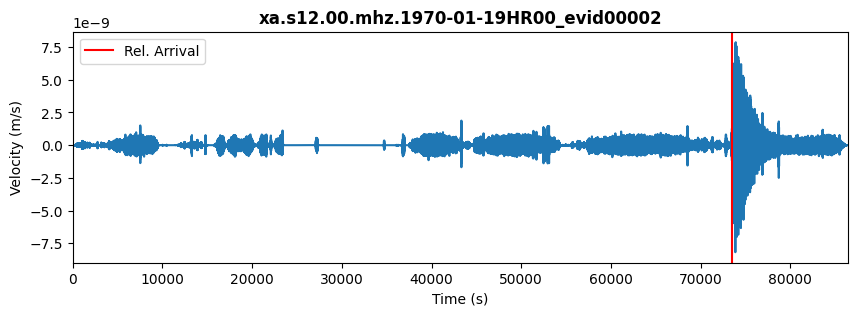

In [5]:
# Read in time steps and velocities
csv_times = np.array(df['time_rel(sec)'].tolist())
csv_data = np.array(df['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{'xa.s12.00.mhz.1970-01-19HR00_evid00002'}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

In [15]:
import pandas as pd
from obspy import read
from obspy.signal.trigger import classic_sta_lta

def read_mseed(file_path):
  """
  Reads an mseed file and returns a pandas DataFrame with data, time, and sampling rate, 
  sorted in ascending order of time.

  Args:
      file_path (str): Path to the mseed file.

  Returns:
      pandas.DataFrame: DataFrame with columns 'data', 'time', and 'sampling_rate'.
  """

  # Read the mseed file
  st = read(file_path)
  tr = st[0]  # Assuming single trace in the mseed file

  # Extract data, time, and sampling rate
  data = tr.data
  times = tr.times()  # Get time values for plotting with matplotlib
  sampling_rate = tr.stats.sampling_rate

  # Create a DataFrame
  df = pd.DataFrame({'time': times, 'data': data, 'sampling_rate': sampling_rate})

  # Sort the DataFrame by time in ascending order
  df.sort_values('time', inplace=True)

  return df


def preprocess_data_using_sta_lta(df, sta_len=120, lta_len=600):
  """
  Preprocesses a dataframe using the STA/LTA method.

  Args:
      df (pandas.DataFrame): The input dataframe with 'data' and 'sampling_rate' columns.
      sta_len (int, optional): Length of the short-term average window in seconds. 
                              Defaults to 120.
      lta_len (int, optional): Length of the long-term average window in seconds. 
                              Defaults to 600.

  Returns:
      pandas.DataFrame: A new dataframe with 'time' and 'data' columns, where 'data'
                       contains the characteristic function values from STA/LTA.
  """

  # Extract data and sampling rate
  tr_data = df['data'].values
  sampling_rate = df['sampling_rate'].values[0]  # Get the single sampling rate value

  # Calculate the characteristic function using STA/LTA
  cft = classic_sta_lta(tr_data, int(sta_len * sampling_rate), int(lta_len * sampling_rate))

  # Create a new DataFrame with time and cft
  preprocessed_df = pd.DataFrame({'time': df['time'], 'data': cft})

  return preprocessed_df


import matplotlib.pyplot as plt

def plot_preprocessed_data(ax, preprocessed_df, arrival_time, title):
    """
    Function to plot preprocessed data and mark detection with arrival time on a given axis.

    Parameters:
    - ax (matplotlib.axes.Axes): Axis object where the plot will be drawn.
    - preprocessed_df (DataFrame): DataFrame containing 'time' and 'data' columns for plotting.
    - arrival_time (float): The x-coordinate (time) where the detection occurs.
    - title (str): Title of the plot.

    Returns:
    - None
    """
    # Plot preprocessed data
    ax.plot(preprocessed_df['time'], preprocessed_df['data'])

    # Mark detection
    ax.axvline(x=arrival_time, color='red', label='Rel. Arrival')
    ax.legend(loc='upper left')

    # Make the plot visually appealing
    ax.set_xlim([min(preprocessed_df['time']), max(preprocessed_df['time'])])
    ax.set_ylabel('RMA value')
    ax.set_xlabel('Time (s)')
    ax.set_title(title, fontweight='bold')


In [7]:
mseed_file_path = r'..\data\lunar\training\data\S12_GradeA\xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed'

In [8]:
mseed_df = read_mseed(mseed_file_path)
preprocessed_df = preprocess_data(mseed_df, sta_len=100, lta_len=70000)

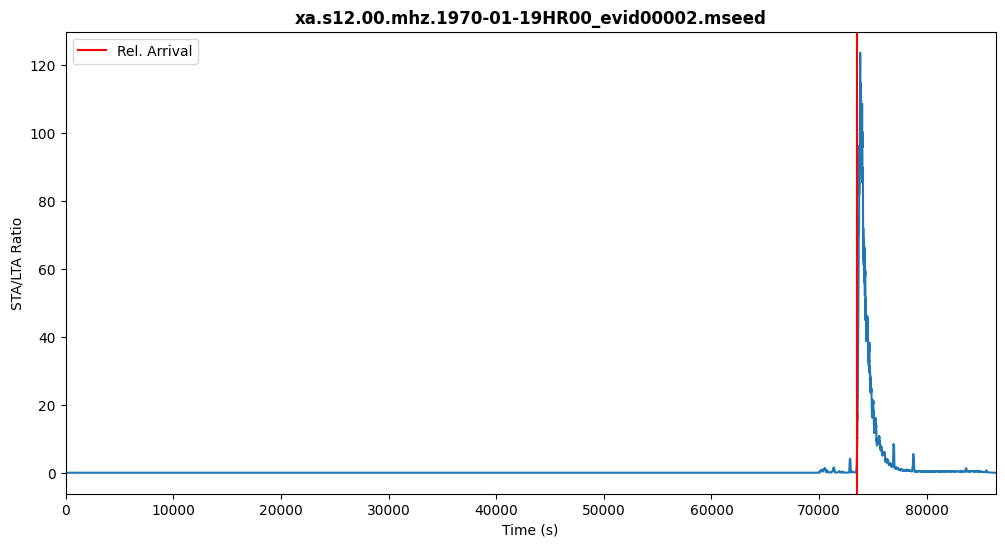

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
plot_preprocessed_data(axs, preprocessed_df, arrival_time, 'xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed')

### Aplying the same technique for all 

In [10]:
mseed_folder_path = r'..\data\lunar\training\data\S12_GradeA'
lunar_data_names = cat['filename'].values

lunar_data_file_path = [os.path.join(mseed_folder_path, f'{file_name}.mseed') for file_name in lunar_data_names]
lunar_data_file_path = [file_path for file_path in lunar_data_file_path if os.path.isfile(file_path)]

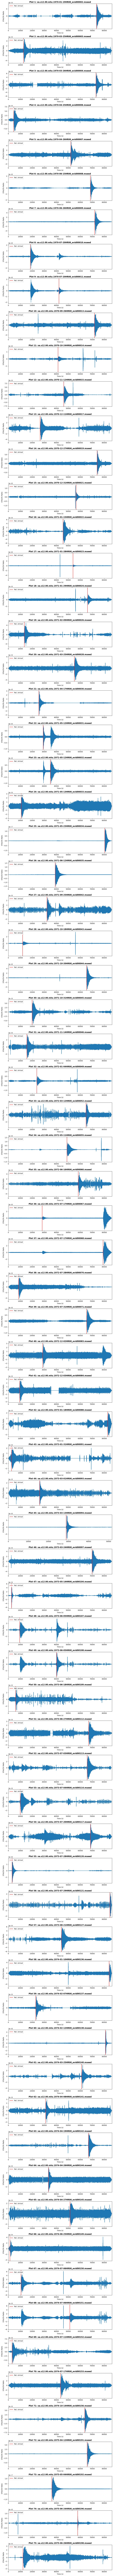

In [11]:
# Create a figure with len(lunar_data_names) subplots
num_plots = len(lunar_data_file_path)
fig, axs = plt.subplots(num_plots, 1, figsize=(10, 3 * num_plots))

# Iterate over lunar_data_file_path and lunar_data_time_rel to plot each subplot
for i, file_path in enumerate(lunar_data_file_path):
    # Read the mseed file into a DataFrame (replace with actual reading function)
    
    mseed_df = read_mseed(file_path)
    #preprocessed_df = preprocess_data(mseed_df, sta_len=100, lta_len=70000)
    
    arrival_time = cat[cat["filename"] == os.path.basename(file_path).replace(".mseed", "")]["time_rel(sec)"].values[0]
    # Plot on the ith axis
    plot_preprocessed_data(axs[i], mseed_df, arrival_time, f"Plot {i+1}: {os.path.basename(file_path)}")


# Adjust layout for better spacing
plt.tight_layout()
plt.show()

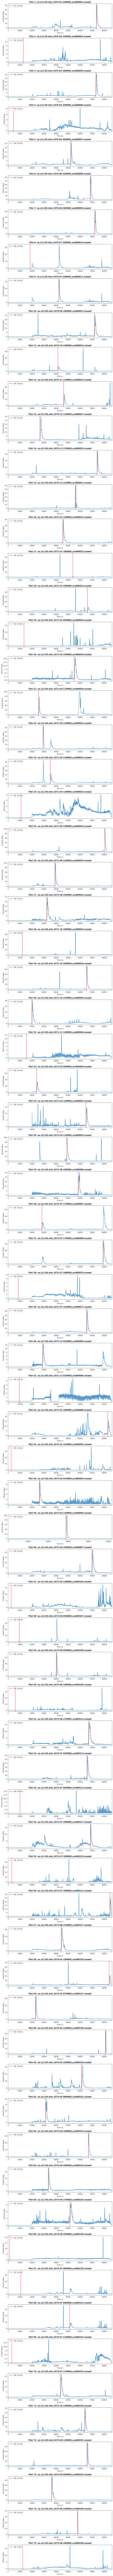

In [16]:
# Create a figure with len(lunar_data_names) subplots
num_plots = len(lunar_data_file_path)
fig, axs = plt.subplots(num_plots, 1, figsize=(10, 3 * num_plots))

# Iterate over lunar_data_file_path and lunar_data_time_rel to plot each subplot
for i, file_path in enumerate(lunar_data_file_path):
    # Read the mseed file into a DataFrame (replace with actual reading function)
    
    mseed_df = read_mseed(file_path)
    preprocessed_df = preprocess_data_using_sta_lta(mseed_df, sta_len=200, lta_len=20000)
    
    arrival_time = cat[cat["filename"] == os.path.basename(file_path).replace(".mseed", "")]["time_rel(sec)"].values[0]
    # Plot on the ith axis
    plot_preprocessed_data(axs[i], preprocessed_df, arrival_time, f"Plot {i+1}: {os.path.basename(file_path)}")


# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [22]:
def preprocess_data_rms(df, window_size=4):
  """
  Preprocesses a dataframe by calculating the absolute root mean square (RMS) 
  over a rolling window.

  Args:
      df (pandas.DataFrame): The input dataframe with a 'data' column.
      window_size (int, optional): The size of the rolling window in samples. 
                                  Defaults to 10.

  Returns:
      pandas.DataFrame: A new dataframe with the 'rms' column containing the 
                       calculated RMS values.
  """

  # Calculate the absolute RMS using a rolling window
  df['data'] = df['data'].abs().rolling(window=window_size, center=True).mean()

  # Drop the initial and final rows with NaN values due to the rolling window
  df.dropna(inplace=True)

  return df

In [23]:
mseed_df = read_mseed(file_path)
preprocessed_df = preprocess_data_rms(mseed_df, window_size=4)

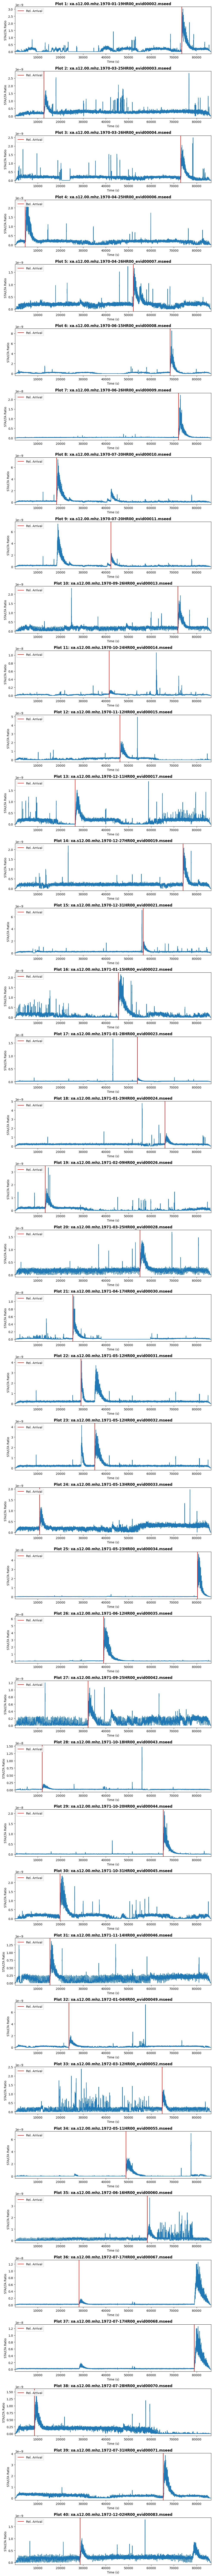

In [28]:
# Create a figure with len(lunar_data_names) subplots
num_plots = len(lunar_data_file_path[:40])
fig, axs = plt.subplots(num_plots, 1, figsize=(10, 3 * num_plots))

# Iterate over lunar_data_file_path and lunar_data_time_rel to plot each subplot
for i, file_path in enumerate(lunar_data_file_path[:40]):
    # Read the mseed file into a DataFrame (replace with actual reading function)
    
    mseed_df = read_mseed(file_path)
    preprocessed_df = preprocess_data_rms(mseed_df, window_size=100)
    
    arrival_time = cat[cat["filename"] == os.path.basename(file_path).replace(".mseed", "")]["time_rel(sec)"].values[0]
    # Plot on the ith axis
    plot_preprocessed_data(axs[i], preprocessed_df, arrival_time, f"Plot {i+1}: {os.path.basename(file_path)}")


# Adjust layout for better spacing
plt.tight_layout()
plt.show()